In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')
import os
import torch
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
import json
from internal.dataparsers.colmap_dataparser import ColmapDataParser
import internal.utils.colmap as colmap_utils
import math

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
torch.set_grad_enabled(False)
torch.set_printoptions(precision=16)

In [4]:
from internal.utils.partitioning_utils import SceneConfig, PartitionableScene

In [5]:
dataset_path = os.path.expanduser("../../datasets/jmsd/perspective_v1/")

# 1. Load dataset

In [6]:
colmap_model = colmap_utils.read_model(os.path.join(dataset_path, "sparse"))
colmap_model = {
    "cameras": colmap_model[0],
    "images": colmap_model[1],
    "points3D": colmap_model[2],
}

len(colmap_model["cameras"]), len(colmap_model["images"]), len(colmap_model["points3D"])

Detected model format: '.bin'


(6, 9642, 115621)

get camera extrinsics

In [7]:
R_list = []
T_list = []
image_name_list = []
image_idx_to_key = []

for idx, key in enumerate(colmap_model["images"]):
    extrinsics = colmap_model["images"][key]
    image_name_list.append(extrinsics.name)

    R = torch.tensor(extrinsics.qvec2rotmat(), dtype=torch.float)
    T = torch.tensor(extrinsics.tvec, dtype=torch.float)

    R_list.append(R)
    T_list.append(T)
    image_idx_to_key.append(key)

R = torch.stack(R_list)
T = torch.stack(T_list)

assert image_idx_to_key[0] == list(colmap_model["images"].keys())[0]
assert image_idx_to_key[-1] == list(colmap_model["images"].keys())[-1]

R.shape, T.shape, len(image_idx_to_key),

(torch.Size([9642, 3, 3]), torch.Size([9642, 3]), 9642)

In [8]:
# calculate camera-to-world transform matrix
w2c = torch.zeros(size=(R.shape[0], 4, 4), dtype=R.dtype)
w2c[:, :3, :3] = R
w2c[:, :3, 3] = T
w2c[:, 3, 3] = 1.
c2w = torch.linalg.inv(w2c)
w2c.shape, c2w.shape

(torch.Size([9642, 4, 4]), torch.Size([9642, 4, 4]))

reorientation

In [9]:
auto_reorient = True
xy_rotation_angle = 30/180*math.pi

if auto_reorient:
    # calculate the up direction of the scene
    # NOTE: 
    #   the calculated direction may not be perfect or even incorrect sometimes, 
    #   in such a situation, you need to provide a correct up vector
    up = -torch.mean(c2w[:, :3, 1], dim=0)
    up = up / torch.linalg.norm(up)

    rotation = ColmapDataParser.rotation_matrix(up, torch.tensor([0, 0, 1], dtype=up.dtype))
    rotation_transform = torch.eye(4, dtype=up.dtype)
    rotation_transform[:3, :3] = rotation 
else:
    # No reorientation: simply use +Z
    up = torch.tensor([0., 0., 1.], dtype=torch.float)
    rotation_transform = torch.eye(4, dtype=up.dtype)
rotation_transform[:3, :3] = rotation_transform[:3, :3]@ torch.tensor([[math.cos(xy_rotation_angle), math.sin(xy_rotation_angle), 0], [-math.sin(xy_rotation_angle), math.cos(xy_rotation_angle), 0], [0, 0, 1]], dtype=up.dtype)
up, rotation_transform

reoriented_camera_centers = c2w[:, :3, 3] @ rotation_transform[:3, :3].T

get points（from colmap）

In [10]:
max_point_index = max(colmap_model["points3D"].keys())
point_xyzs = torch.zeros((max_point_index + 1, 3), dtype=torch.float)
point_rgbs = torch.zeros((max_point_index + 1, 3), dtype=torch.uint8)
point_errors = torch.ones((max_point_index + 1), dtype=torch.float).fill_(255.)
point_n_images = torch.zeros((max_point_index + 1), dtype=torch.int)

for idx, point in tqdm(colmap_model["points3D"].items()):
    point_xyzs[idx] = torch.from_numpy(point.xyz)
    point_rgbs[idx] = torch.from_numpy(point.rgb)
    point_errors[idx] = torch.from_numpy(point.error)
    point_n_images[idx] = point.image_ids.shape[0]

reoriented_point_cloud_xyz = point_xyzs @ rotation_transform[:3, :3].T

valid_point_mask = point_n_images > 0
valid_reoriented_point_xyzs = reoriented_point_cloud_xyz[valid_point_mask]
valid_point_rgbs = point_rgbs[valid_point_mask]
len(valid_reoriented_point_xyzs), len(valid_point_rgbs)

# filter out points with large errors
min_cameras = 3
max_errors = 2.

shared_point_mask = torch.logical_and(
    torch.ge(point_n_images, min_cameras),
    torch.le(point_errors, max_errors),
)

shared_point_mask.sum()

  0%|          | 0/115621 [00:00<?, ?it/s]

tensor(80360)

get point (from ply file)

In [11]:
from plyfile import PlyData, PlyElement
import numpy as np
ply_file = os.path.join(dataset_path, "merged_with_lines_subsampled.ply")
ply_data = PlyData.read(ply_file)
vertices = ply_data['vertex']
point_xyzs = torch.from_numpy(np.stack([vertices['x'], vertices['y'], vertices['z']], axis=1))
point_rgbs = torch.from_numpy(np.stack([vertices['red'], vertices['green'], vertices['blue']], axis=1))
reoriented_point_cloud_xyz = point_xyzs @ rotation_transform[:3, :3].T
shared_point_mask = np.ones(point_xyzs.shape[0], dtype=bool)
reoriented_point_cloud_xyz.shape

torch.Size([1278721, 3])

In [12]:
scene = PartitionableScene(camera_centers=reoriented_camera_centers[..., :2])

In [13]:
scene.get_bounding_box_by_points(points=reoriented_point_cloud_xyz[shared_point_mask])

MinMaxBoundingBox(min=tensor([-86.6527328491210938, -95.0743179321289062]), max=tensor([75.4019927978515625, 93.8535079956054688]))

plot the scene, confirming that it shows in top view

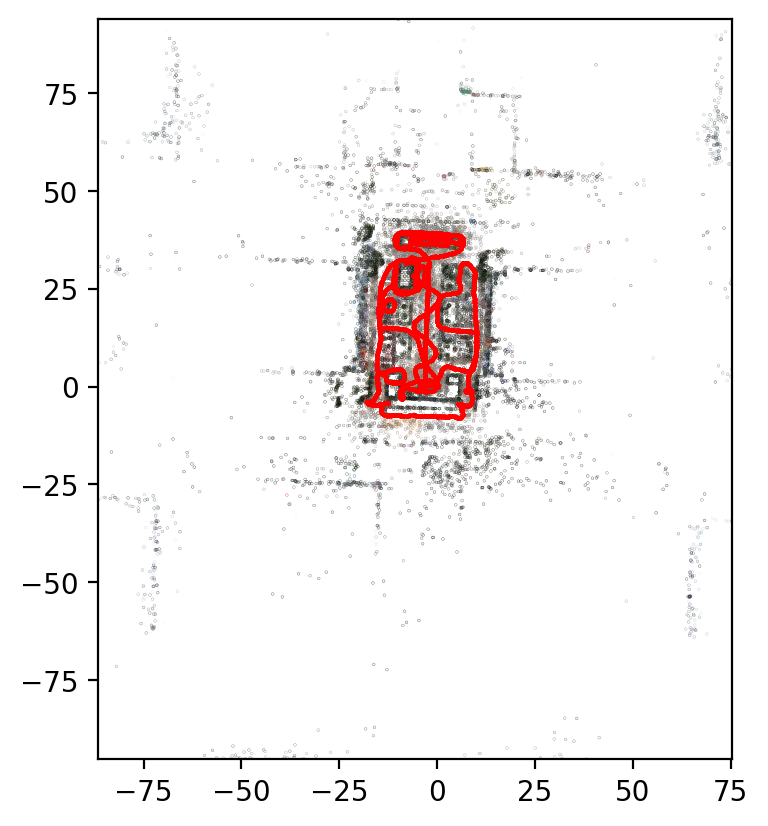

In [14]:
sparsify_points = 4
fig, ax = plt.subplots()
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(scene.point_based_bounding_box.min[0], scene.point_based_bounding_box.max[0])
ax.set_ylim(scene.point_based_bounding_box.min[1], scene.point_based_bounding_box.max[1])
ax.scatter(valid_reoriented_point_xyzs[::sparsify_points, 0], valid_reoriented_point_xyzs[::sparsify_points, 1], c=valid_point_rgbs[::sparsify_points] / 255., s=0.01)
ax.scatter(reoriented_camera_centers[:, 0], reoriented_camera_centers[:, 1], s=0.2, c="red")
plt.show()

# 2. Build partitions

choose scene origin and partition size

In [43]:
# NOTE: remember to update the `origin` and `partition_size`
scene_config = SceneConfig(
    origin=torch.tensor([-5., 15.]),
    partition_size=20,
)
scene.scene_config = scene_config

calculate bounding box and number of partitions

In [44]:
scene.get_bounding_box_by_camera_centers()

MinMaxBoundingBox(min=tensor([-18.0596942901611328,  -7.9897027015686035]), max=tensor([10.1154060363769531, 39.5459251403808594]))

In [45]:
scene.get_scene_bounding_box()

SceneBoundingBox(bounding_box=MinMaxBoundingBox(min=tensor([-25., -25.]), max=tensor([15., 55.])), n_partitions=tensor([2, 4]), origin_partition_offset=tensor([-1, -2]))

plot bounding box

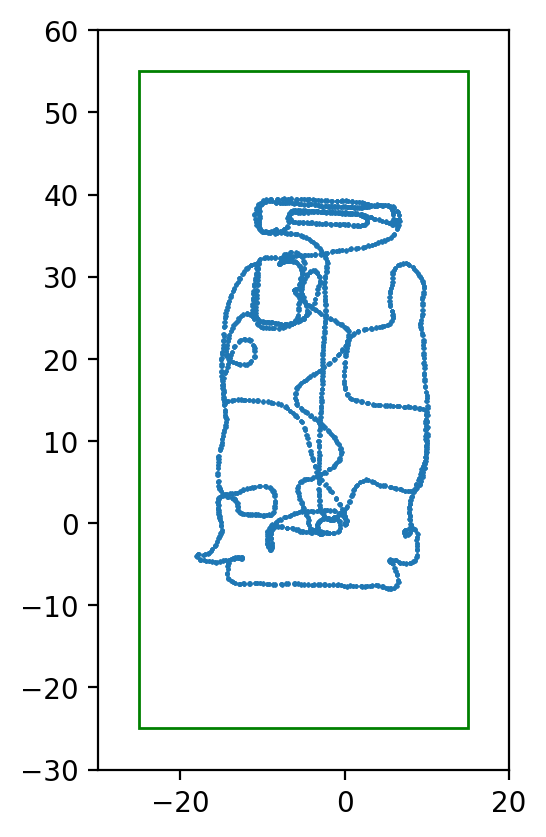

In [46]:
scene.plot(scene.plot_scene_bounding_box)

build partition coordinates

In [47]:
scene.build_partition_coordinates()

PartitionCoordinates(id=tensor([[-1, -2],
        [ 0, -2],
        [-1, -1],
        [ 0, -1],
        [-1,  0],
        [ 0,  0],
        [-1,  1],
        [ 0,  1]], dtype=torch.int32), xy=tensor([[-25., -25.],
        [ -5., -25.],
        [-25.,  -5.],
        [ -5.,  -5.],
        [-25.,  15.],
        [ -5.,  15.],
        [-25.,  35.],
        [ -5.,  35.]]), size=tensor([[20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.]]))

plot partitions

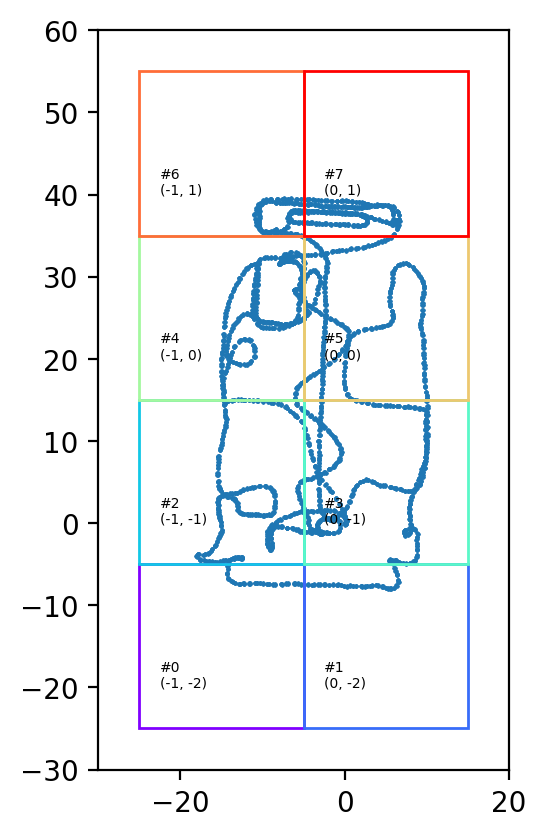

In [48]:
scene.plot(scene.plot_partitions)

# 3. Assign images to partitions

## 3.1. Location based assignment

In [49]:
scene_config.location_based_enlarge = 0.1

In [50]:
scene.camera_center_based_partition_assignment().sum(-1)

tensor([ 489,  396, 2220, 2688, 2694, 2940,  957, 1722])

## 3.2. Visibility based assignment

the visibility is calculated from 3D points of every camera

In [51]:
# some parameters may need to be changed
scene_config.visibility_based_distance = 0.9  # enlarge bounding box by `partition_size * max_visible_distance`, only those cameras inside this enlarged box will be used for visibility based assignment
scene_config.visibility_threshold = 1. / 9.
# convex hull based visibility
scene_config.convex_hull_based_visibility = True
scene_config.visibility_based_partition_enlarge = 0.1

define image 3D point getter

start calculating visibilities

In [52]:
reliable_points = None
if scene_config.convex_hull_based_visibility:
    print("Convex hull based")

    def project_points(image_idx: int, points, expand: float = 64):
        image_key = image_idx_to_key[image_idx]  # the id in colmap sparse model

        camera = colmap_model["cameras"][colmap_model["images"][image_key].camera_id]

        assert camera.model == "PINHOLE"

        K = torch.eye(4, dtype=points.dtype, device=points.device)
        K[0, 0] = camera.params[0]
        K[1, 1] = camera.params[1]
        K[0, 2] = camera.params[2]
        K[1, 2] = camera.params[3]

        full_projection = K @ w2c[image_idx].to(device=points.device)

        points_homogenous = points @ full_projection[:3, :3].T + full_projection[:3, 3]
        points_front = points_homogenous[points_homogenous[:, -1] > 0.01]
        points_uv = (points_front / points_front[:, -1:])[:, :2]

        image_shape = torch.tensor([[camera.width, camera.height]], dtype=torch.float, device=points_uv.device)

        points_in_image_mask = torch.logical_and(
            torch.prod(points_uv >= 0. - expand, dim=-1).bool(),
            torch.prod(points_uv < (image_shape + expand), dim=-1).bool(),
        )

        valid_uv = points_uv[points_in_image_mask]

        return torch.min(torch.clamp(valid_uv, min=0.), image_shape).cpu()

    reliable_points = point_xyzs[shared_point_mask].cuda()

    def get_image_points(image_idx: int):
        image_key = image_idx_to_key[image_idx]  # the id in colmap sparse model

        # project all points (project non-reoriented points)
        projected_points = project_points(image_idx, reliable_points)

        # get valid points
        points_xys = torch.from_numpy(colmap_model["images"][image_key].xys)
        points_ids = torch.from_numpy(colmap_model["images"][image_key].point3D_ids)
        valid_mask = points_ids > 0
        points_xys = points_xys[valid_mask]
        points_ids = points_ids[valid_mask]

        # filter
        points_ids *= shared_point_mask[points_ids]
        filter_mask = points_ids > 0
        points_ids = points_ids[filter_mask]
        points_xys = points_xys[filter_mask]

        return points_xys, reoriented_point_cloud_xyz[points_ids], projected_points
else:
    print("point based")

    def get_image_points(image_idx: int):
        image_key = image_idx_to_key[image_idx]
        # get valid points
        points_ids = torch.from_numpy(colmap_model["images"][image_key].point3D_ids)
        points_ids = points_ids[points_ids > 0]

        # filter
        points_ids *= shared_point_mask[points_ids]
        points_ids = points_ids[points_ids > 0]

        return reoriented_point_cloud_xyz[points_ids]

print(scene.calculate_camera_visibilities(
    point_getter=get_image_points,
    device=reoriented_point_cloud_xyz.device,
).shape)
del reliable_points
torch.cuda.empty_cache()

Convex hull based


  0%|          | 0/9642 [00:00<?, ?it/s]

/tmp/ipykernel_1130916/1644061934.py:51: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  points_ids *= shared_point_mask[points_ids]


torch.Size([8, 9642])


In [ ]:
# preview the convex hull

reliable_points = point_xyzs[shared_point_mask]


def plot_convex_hull(image_idx: int):
    from internal.utils.partitioning_utils import Partitioning
    points_2d, points_3d, projected_points = get_image_points(image_idx)
    visibilities, scene_convex_hull, (partition_convex_hull_list, is_in_bounding_boxes) = Partitioning.calculate_convex_hull_based_visibilities(
        scene.partition_coordinates.get_bounding_boxes(enlarge=0.).to(reoriented_point_cloud_xyz.device),
        points_2d=points_2d,
        points_3d=points_3d[:, :2],
        projected_points=projected_points,
    )

    from PIL import Image
    with Image.open(os.path.join(dataset_path, "images", colmap_model["images"][image_idx_to_key[image_idx]].name)) as i:
        fig, ax = plt.subplots()
        ax.imshow(i)
        ax.scatter(projected_points[:, 0], projected_points[:, 1], s=0.1)
        ax.plot(projected_points[scene_convex_hull.vertices, 0], projected_points[scene_convex_hull.vertices, 1], 'r--', lw=2)
        ax.plot(projected_points[scene_convex_hull.vertices[0], 0], projected_points[scene_convex_hull.vertices[0], 1], 'ro')
        fig.show()

        for partition_idx, partition_convex_hull in enumerate(partition_convex_hull_list):
            if partition_convex_hull is None:
                continue

            fig, ax = plt.subplots()
            ax.imshow(i)
            ax.title.set_text(scene.partition_coordinates.get_str_id(partition_idx))
            partition_feature_points = points_2d[is_in_bounding_boxes[partition_idx]]
            ax.scatter(partition_feature_points[:, 0], partition_feature_points[:, 1], s=0.1)

            for simplex in partition_convex_hull.simplices:
                ax.plot(partition_feature_points[simplex, 0], partition_feature_points[simplex, 1], 'c')
            ax.plot(
                partition_feature_points[partition_convex_hull.vertices, 0],
                partition_feature_points[partition_convex_hull.vertices, 1],
                'o',
                mec='r',
                color='none',
                lw=1,
                markersize=10,
            )

            fig.show()

    print("visibilities={}".format(visibilities))
    print(scene_convex_hull.volume)


plot_convex_hull(512)

assign cameras to partitions based on visibilities

In [53]:
scene.visibility_based_partition_assignment().sum(dim=-1)

tensor([1924, 1815, 5218, 4775, 6035, 5829, 2315, 2256])

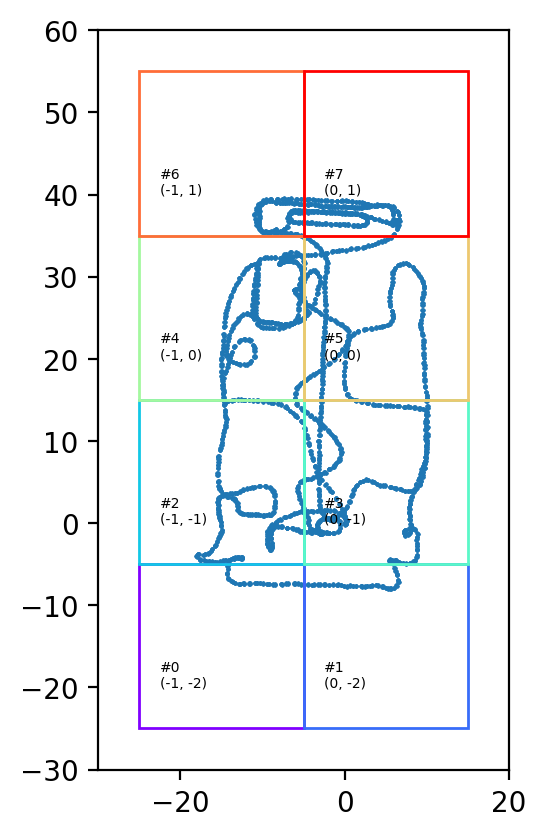

In [54]:
# merge small partitions, you can revert merging by calling `scene.unmerge()`
scene.merge_no_location_based_partitions()
scene.plot(scene.plot_partitions)

# 4. Preview

In [55]:
output_path = os.path.join(dataset_path, scene.build_output_dirname())
try:
    assert os.path.exists(os.path.join(output_path, "partitions.pt")) is False, output_path
except:
    del output_path
    raise
os.makedirs(output_path, exist_ok=True)
output_path

'../../datasets/jmsd/perspective_v1/partitions-size_20-enlarge_0.1-convex_hull_visibility_0.9_0.11'

In [56]:
max_plot_points = 51_200
plot_point_sparsify = max(valid_reoriented_point_xyzs.shape[0] // max_plot_points, 1)
plot_point_sparsify

2

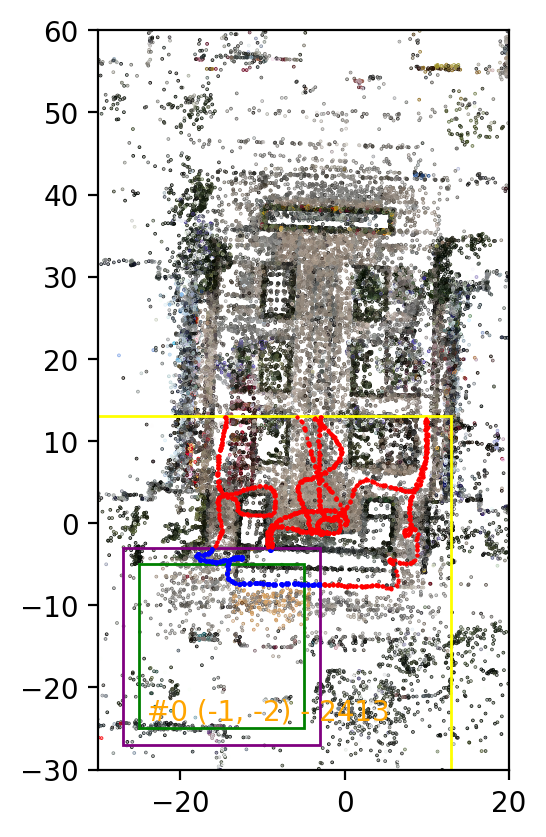

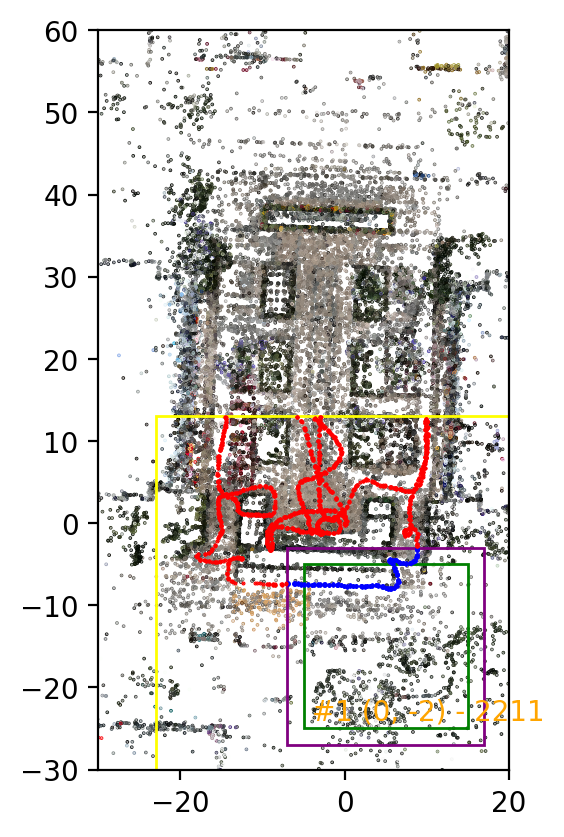

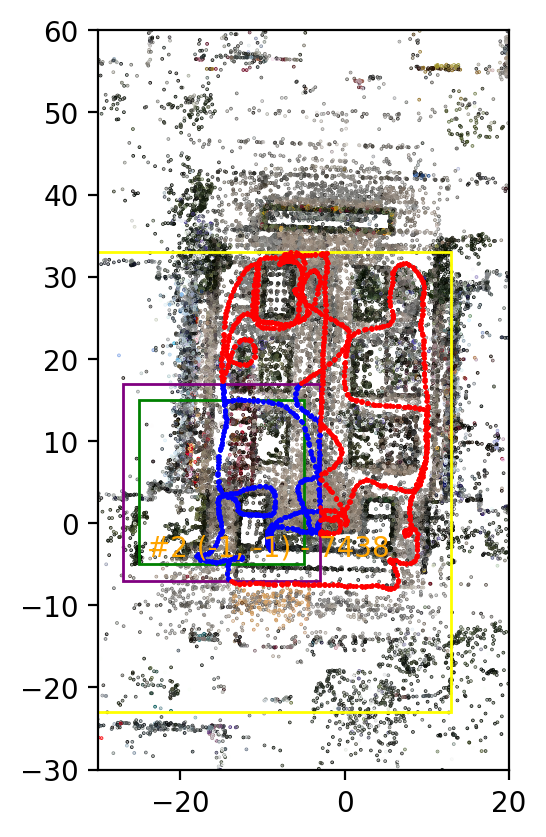

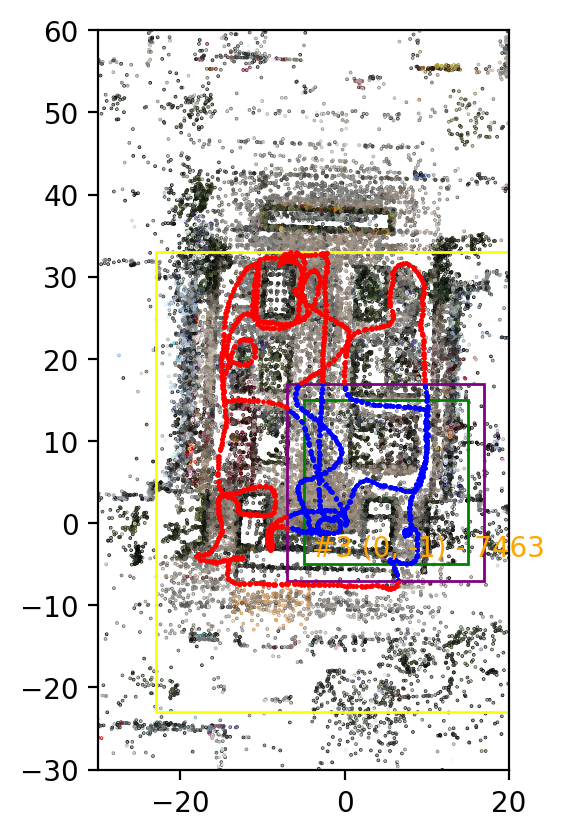

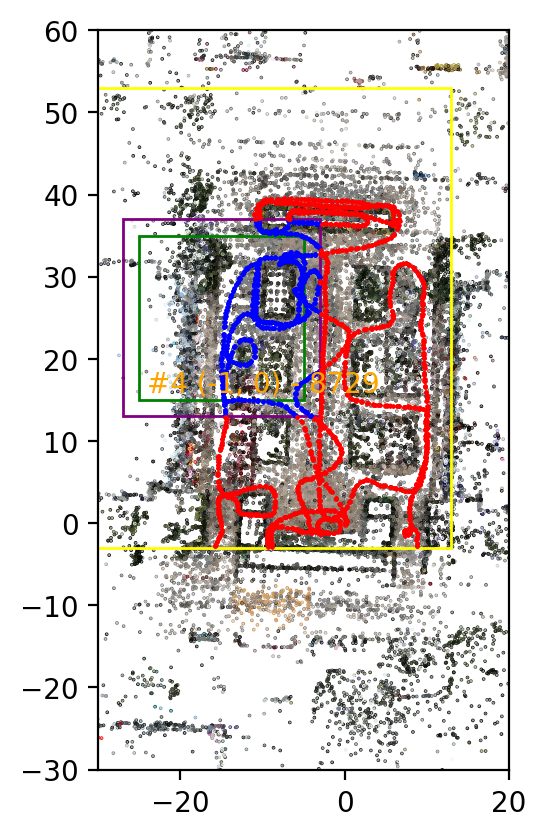

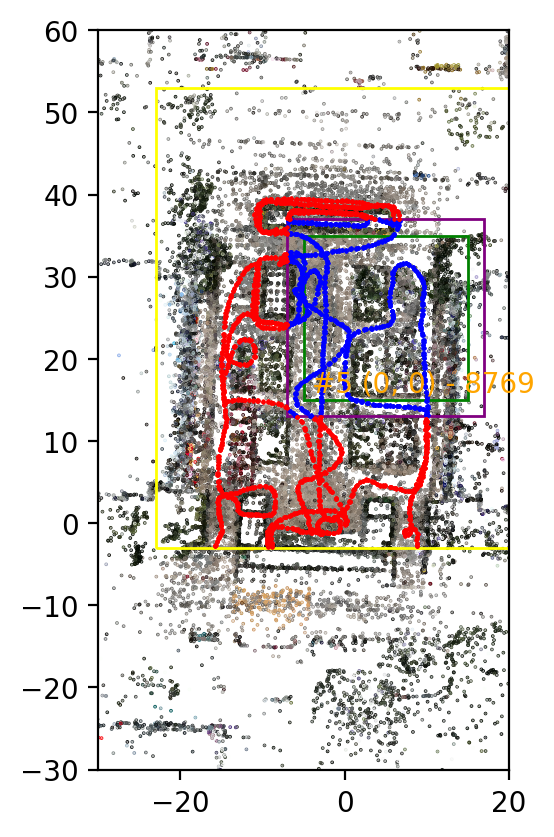

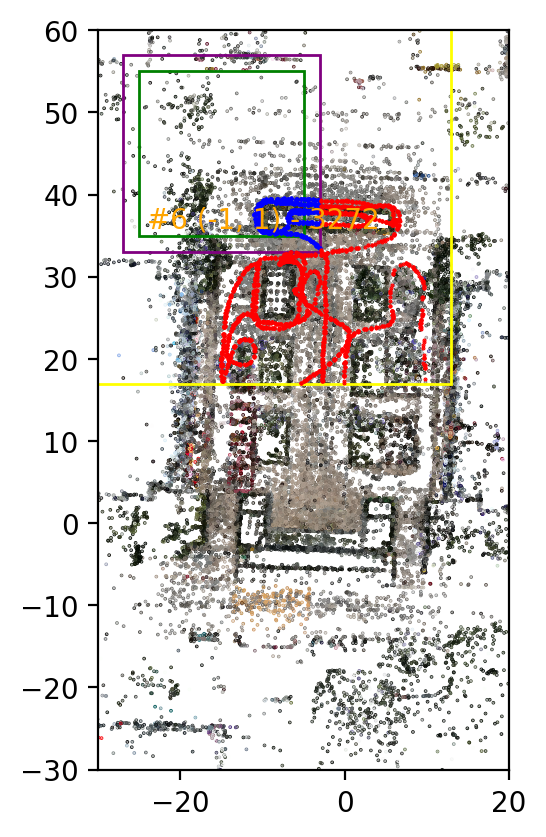

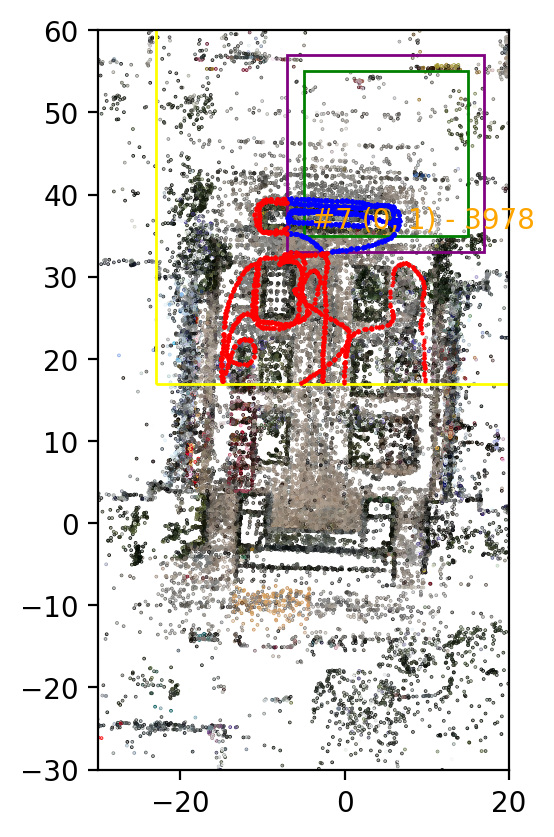

In [57]:
# plot the cameras assigned to the partitions
for idx in range(len(scene.partition_coordinates)):
    scene.save_plot(
        scene.plot_partition_assigned_cameras,
        os.path.join(output_path, "{}.png".format(scene.partition_coordinates.get_str_id(idx))),
        idx,
        valid_reoriented_point_xyzs,
        valid_point_rgbs,
        point_sparsify=plot_point_sparsify,
    )
# scene.plot(scene.plot_partition_assigned_cameras, 13, valid_reoriented_point_xyzs, valid_point_rgbs, point_sparsify=plot_point_sparsify)
# scene.plot(scene.plot_partition_assigned_cameras, 15, valid_reoriented_point_xyzs, valid_point_rgbs, point_sparsify=plot_point_sparsify)

# 5. Saving

In [58]:
torch.load(scene.save(
    output_path,
    extra_data={
        "up": up,
        "rotation_transform": rotation_transform,
    }
), weights_only=False)

{'scene_config': {'origin': tensor([-5., 15.]),
  'partition_size': 20,
  'location_based_enlarge': 0.1,
  'visibility_based_distance': 0.9,
  'visibility_based_partition_enlarge': 0.1,
  'visibility_threshold': 0.1111111111111111,
  'visibility_based_distance_enlarge_on_no_location_based': 4.0,
  'visibility_threshold_reduce_on_no_location_based': 4.0,
  'convex_hull_based_visibility': True},
 'scene_bounding_box': {'bounding_box': {'min': tensor([-25., -25.]),
   'max': tensor([15., 55.])},
  'n_partitions': tensor([2, 4]),
  'origin_partition_offset': tensor([-1, -2])},
 'partition_coordinates': {'id': tensor([[-1, -2],
          [ 0, -2],
          [-1, -1],
          [ 0, -1],
          [-1,  0],
          [ 0,  0],
          [-1,  1],
          [ 0,  1]], dtype=torch.int32),
  'xy': tensor([[-25., -25.],
          [ -5., -25.],
          [-25.,  -5.],
          [ -5.,  -5.],
          [-25.,  15.],
          [ -5.,  15.],
          [-25.,  35.],
          [ -5.,  35.]]),
  'size'

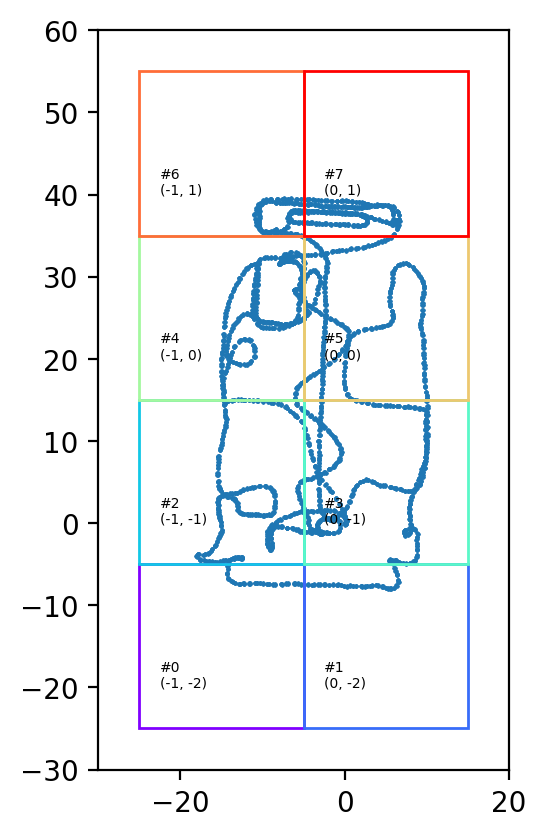

In [59]:
scene.save_plot(scene.plot_partitions, os.path.join(output_path, "partitions.png"))

In [60]:
# TODO: partitioning recursively on those that still contain a large number of images
is_images_assigned_to_partitions = torch.logical_or(scene.is_camera_in_partition, scene.is_partitions_visible_to_cameras)
n_assigned_images = is_images_assigned_to_partitions.sum(-1)
for partition_idx in range(is_images_assigned_to_partitions.shape[0]):
    print("({}, {}): {}".format(
        scene.partition_coordinates.id[partition_idx][0].item(),
        scene.partition_coordinates.id[partition_idx][1].item(),
        n_assigned_images[partition_idx].item(),
    ))

(-1, -2): 2413
(0, -2): 2211
(-1, -1): 7438
(0, -1): 7463
(-1, 0): 8729
(0, 0): 8769
(-1, 1): 3272
(0, 1): 3978


write image lists

In [61]:
written_idx_list = []
for partition_idx in tqdm(list(range(is_images_assigned_to_partitions.shape[0]))):
    partition_image_indices = is_images_assigned_to_partitions[partition_idx].nonzero().squeeze(-1).tolist()
    if len(partition_image_indices) == 0:
        continue
        
    written_idx_list.append(partition_idx)
        
    camera_list = []
    
    with open(os.path.join(output_path, "{}.txt".format(scene.partition_coordinates.get_str_id(partition_idx))), "w") as f:
        for image_index in partition_image_indices:
            f.write(image_name_list[image_index])
            f.write("\n")
            
            # below camera list is just for visualization, not for training, so its camera intrinsics are fixed values
            color = [0, 0, 255]
            if scene.is_partitions_visible_to_cameras[partition_idx][image_index]:
                color = [255, 0, 0]
            camera_list.append({
                "id": image_index,
                "img_name": image_name_list[image_index],
                "width": 1920,
                "height": 1080,
                "position": c2w[image_index][:3, 3].numpy().tolist(),
                "rotation": c2w[image_index][:3, :3].numpy().tolist(),
                "fx": 1600,
                "fy": 1600,
                "color": color,
            })
            
    with open(os.path.join(
            output_path, 
            f"cameras-{scene.partition_coordinates.get_str_id(partition_idx)}.json",
    ), "w") as f:
        json.dump(camera_list, f, indent=4, ensure_ascii=False)

  0%|          | 0/8 [00:00<?, ?it/s]

In [62]:
max_store_points = 512_000
store_point_step = max(valid_point_rgbs.shape[0] // max_store_points, 1)
from internal.utils.graphics_utils import store_ply
store_ply(os.path.join(output_path, "points.ply"), point_xyzs[valid_point_mask][::store_point_step], valid_point_rgbs[::store_point_step])

IndexError: The shape of the mask [115622] at index 0 does not match the shape of the indexed tensor [1278721, 3] at index 0

In [188]:
print("Run below commands to visualize the partitions in web viewer:\n")
for partition_idx in written_idx_list:
    id_str = scene.partition_coordinates.get_str_id(partition_idx)
    print("python utils/show_cameras.py \\\n    '{}' \\\n    --points='{}' \\\n --up {:.3f} {:.3f} {:.3f} \n".format(
        os.path.join(output_path, "cameras-{}.json".format(id_str)),
        os.path.join(output_path, "points.ply"),
        *(up.tolist()),
    ))

Run below commands to visualize the partitions in web viewer:

python utils/show_cameras.py \
    '../../datasets/jmsd/perspective_v1/partitions-size_15.0-enlarge_0.1-convex_hull_visibility_0.9_0.11/cameras--02_-01.json' \
    --points='../../datasets/jmsd/perspective_v1/partitions-size_15.0-enlarge_0.1-convex_hull_visibility_0.9_0.11/points.ply' \
 --up 0.013 -0.001 1.000 

python utils/show_cameras.py \
    '../../datasets/jmsd/perspective_v1/partitions-size_15.0-enlarge_0.1-convex_hull_visibility_0.9_0.11/cameras--01_-01.json' \
    --points='../../datasets/jmsd/perspective_v1/partitions-size_15.0-enlarge_0.1-convex_hull_visibility_0.9_0.11/points.ply' \
 --up 0.013 -0.001 1.000 

python utils/show_cameras.py \
    '../../datasets/jmsd/perspective_v1/partitions-size_15.0-enlarge_0.1-convex_hull_visibility_0.9_0.11/cameras-000_-01.json' \
    --points='../../datasets/jmsd/perspective_v1/partitions-size_15.0-enlarge_0.1-convex_hull_visibility_0.9_0.11/points.ply' \
 --up 0.013 -0.001 